In [6]:
!nvidia-smi

Mon Apr 21 11:36:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   64C    P0             15W /   60W |     534MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPUs detected:", tf.config.list_physical_devices('GPU'))

from tensorflow.python.platform import build_info as tf_build_info
print("CUDA version:", tf_build_info.build_info)
print("Built with CUDA:", tf.test.is_built_with_cuda())

TensorFlow version: 2.19.0
GPUs detected: []
CUDA version: OrderedDict([('is_cuda_build', False), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll')])
Built with CUDA: False


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2

# Reading the data

In [9]:
working_directory: str = os.getcwd()

In [10]:
DIR: dict[str, str] = {
    "Abnormal_Sperm": os.path.join(working_directory, "Abnormal_Sperm"),
    "Normal_Sperm": os.path.join(working_directory, "Normal_Sperm"),
    "Non_Sperm": os.path.join(working_directory, "Non_Sperm"),
}

In [11]:
count: int = sum(len(os.listdir(path)) for path in DIR.values())
for title, path in DIR.items():
    print(f"{title}: {len(os.listdir(path))} Percentage: {len(os.listdir(path)) / count * 100:.2f}%")

Abnormal_Sperm: 1005 Percentage: 33.50%
Normal_Sperm: 1021 Percentage: 34.03%
Non_Sperm: 974 Percentage: 32.47%


In [12]:
images: list[np.ndarray] = []
labels: list[str] = []
def read_resize(path: str, label) -> np.ndarray:
    image: np.ndarray = plt.imread(path)
    post_image = tf.image.convert_image_dtype(image, tf.float32)
    post_image = tf.image.resize(post_image, [128, 128])
    images.append(tf.keras.utils.img_to_array(post_image))
    labels.append(label)

for title, path in DIR.items():
    images_in_dir: list[str] = os.listdir(path)
    for image in images_in_dir:
        read_resize(os.path.join(path, image), title)
    

The dataset is almost balanced so there should be no need to try to balance the data.

# Visualization

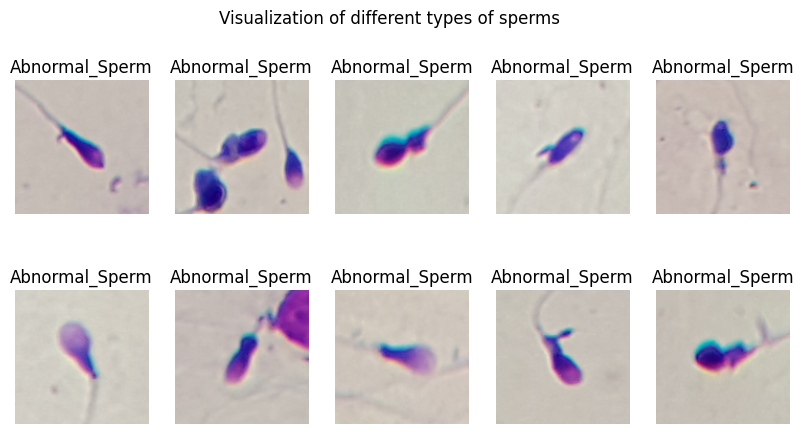

In [13]:
plt.figure(figsize=(10, 5))
for i, (title, image) in enumerate(zip(labels, images), 1):
    if i == 11:
        break
    plt.subplot(2, 5, i)
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
plt.suptitle("Visualization of different types of sperms")
plt.show()

In [14]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics


In [15]:
data_augmentation: models.Sequential = models.Sequential([
    layers.InputLayer(shape=(128, 128, 3)),
    # layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

In [16]:
model: models.Sequential = models.Sequential([
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax"),
])

model.compile(optimizer=optimizers.Adam(0.001), loss=losses.SparseCategoricalCrossentropy(), metrics=[metrics.SparseCategoricalAccuracy()])

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.python.data.ops.dataset_ops import DatasetV2

def set_labels(labels) -> list[int]:
    label_dictionary: dict[str, int] = {
    "Abnormal_Sperm": 0,
    "Normal_Sperm": 1,
    "Non_Sperm": 2
    }
    return [label_dictionary[label] for label in labels]

def divide_dataset(dataset: DatasetV2, test_size=0.1, val_size=0.1) -> tuple[DatasetV2, DatasetV2, DatasetV2]:
    train_size: float = int(len(dataset) *  (1 - test_size - val_size))
    test_size: int = int(len(dataset) * test_size)
    train: DatasetV2 = dataset.take(train_size)
    test: DatasetV2 = dataset.skip(train_size).take(test_size)
    val: DatasetV2 = dataset.skip(train_size + test_size)
    return train, test, val


In [19]:
labels: list[int] = set_labels(labels)

dataset: DatasetV2 = (tf.data.Dataset.from_tensor_slices((images, labels))
.batch(32)
.shuffle(32)
.prefetch(tf.data.AUTOTUNE))

train, test, val = divide_dataset(dataset)

In [20]:
history = model.fit(train, epochs=20, validation_data=(val))

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - loss: 2.4050 - sparse_categorical_accuracy: 0.5311 - val_loss: 0.8621 - val_sparse_categorical_accuracy: 0.7949
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - loss: 1.2413 - sparse_categorical_accuracy: 0.3413 - val_loss: 1.0928 - val_sparse_categorical_accuracy: 0.6000
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - loss: 1.0753 - sparse_categorical_accuracy: 0.4564 - val_loss: 1.0959 - val_sparse_categorical_accuracy: 0.6656
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - loss: 1.1029 - sparse_categorical_accuracy: 0.1582 - val_loss: 1.1027 - val_sparse_categorical_accuracy: 0.3000
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - loss: 1.0890 - sparse_categorical_accuracy: 0.3808 - val_loss: 1.1336 - val_sparse_categorical_accuracy: 0.2051
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - loss: 1.0602 - sparse_categorical_accuracy: 0.3178 - val_loss: 1.2778 - val_sparse_categorical_accuracy: 0.568

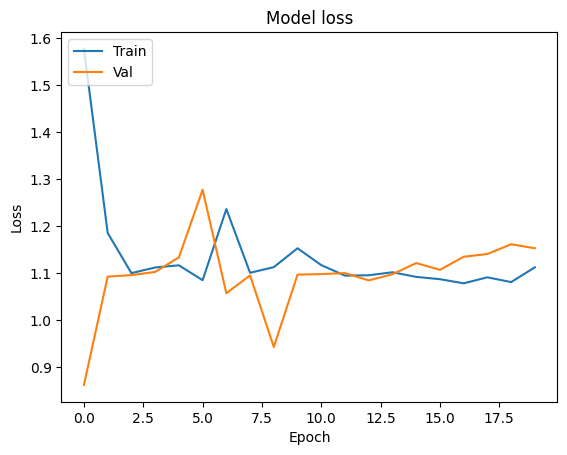

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

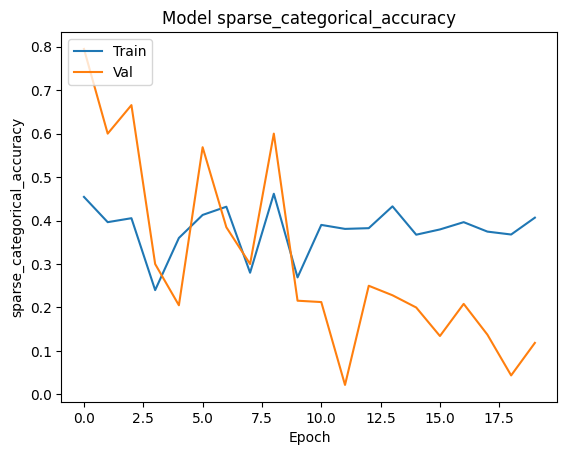

In [22]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model sparse_categorical_accuracy')
plt.ylabel('sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [23]:
predicted: np.ndarray = model.predict(test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [24]:
predicted_choices: list[np.int64] = list(np.argmax(predicted, axis=1))

In [25]:
actual = []
for i in test.as_numpy_iterator():
    actual.extend(i[1])

In [26]:
def mark(actual, predicted):
    return [1 if a == p else 0 for a, p in zip(actual, predicted)]
print("Accuracy:", sum(mark(actual, predicted_choices)) / len(actual))

Accuracy: 0.1111111111111111


In [ ]:
sample: tuple[np.ndarray, np.ndarray] = test.as_numpy_iterator().next()

In [46]:
image, label = sample

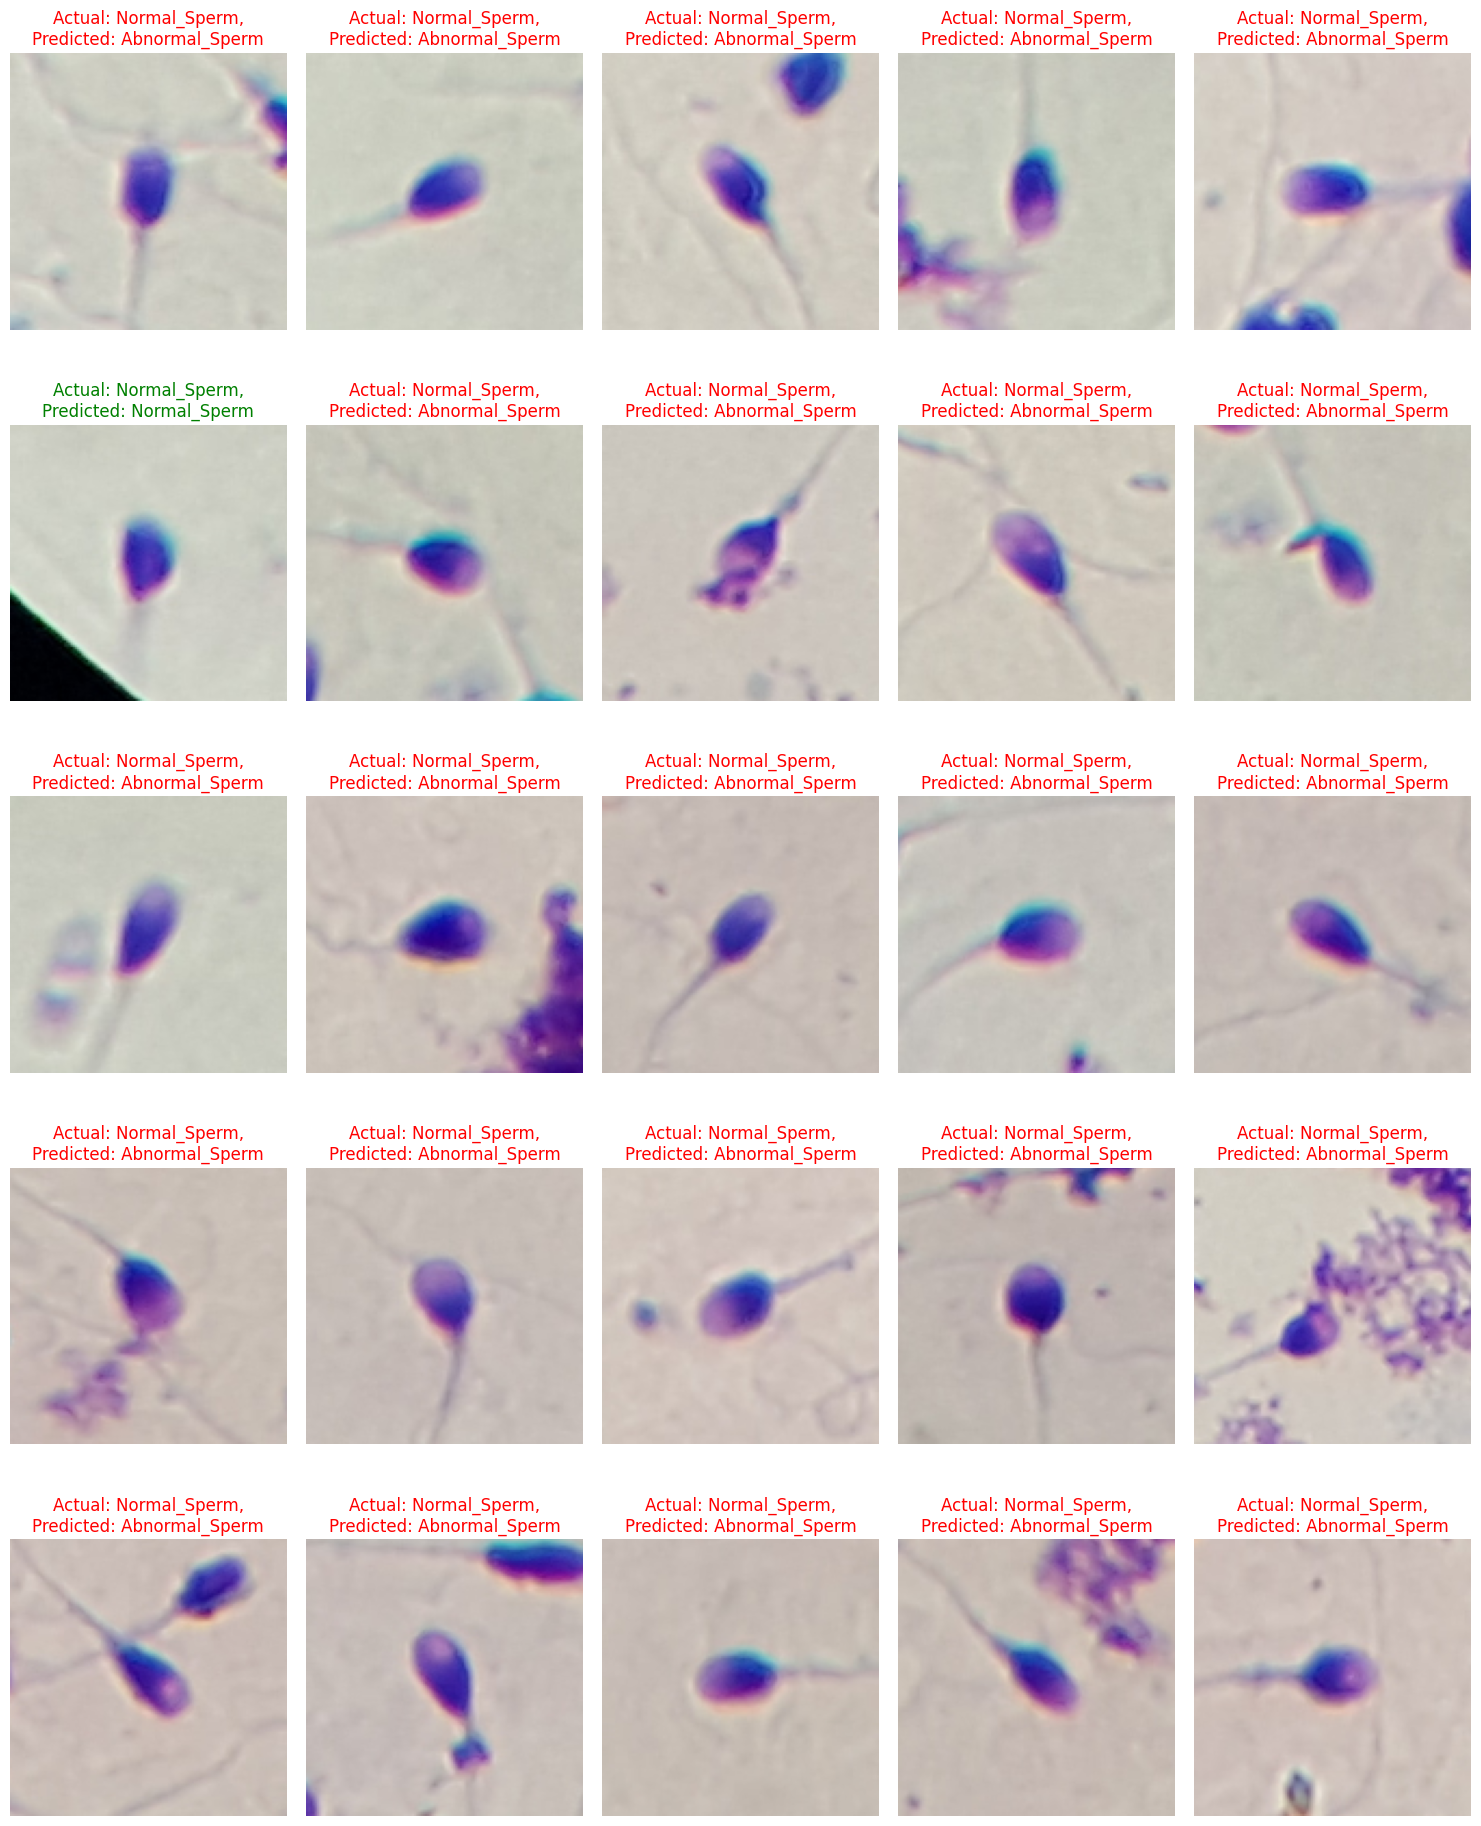

In [57]:
plt.figure(figsize=(15, 20))
rev_label_dict: dict[int, str] = {
    0: "Abnormal_Sperm",
    2: "Non_Sperm",
    1: "Normal_Sperm"
}

for i, (x, y) in enumerate(zip(image, label), 1):
    if i > 25:
        break
    plt.subplot(5, 5, i)
    prediction = np.argmax(model.predict(tf.expand_dims(x, 0), verbose=0))
    plt.imshow(x)
    plt.axis("off")
    plt.tight_layout(pad=1.4)
    plt.title(f"Actual: {rev_label_dict[y]},\nPredicted: {rev_label_dict[prediction]}", color="green" if y == prediction else "red")
plt.show()

In [48]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [49]:
x = pretrained_model.output
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(3, activation="softmax")(x)
model_vgg = Model(pretrained_model.input, x)
model_vgg.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [58]:
model_vgg.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,779 (60.13 MB)

 Trainable params: 15,763,779 (60.13 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
vgg_history = model_vgg.fit(train, epochs=10, validation_data=(val))

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.5926 - loss: 1.8800 - val_accuracy: 0.5897 - val_loss: 5.2182
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.3446 - loss: 2.1802 - val_accuracy: 0.8000 - val_loss: 0.6790
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.3333 - loss: 2.1477 - val_accuracy: 0.8000 - val_loss: 1.0128
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.3358 - loss: 1.1060 - val_accuracy: 0.2000 - val_loss: 1.1221
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.6331 - loss: 1.0761 - val_accuracy: 0.2000 - val_loss: 1.1245
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.5753 - loss: 1.0704 - val_accuracy: 0.3077 - val_loss: 1.1290
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.6316 - loss: 1.0599 - val_accuracy: 0.1000 - val_loss: 1.1480
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.6236 - loss: 1.0523 - val_accuracy: 0.1000 - v

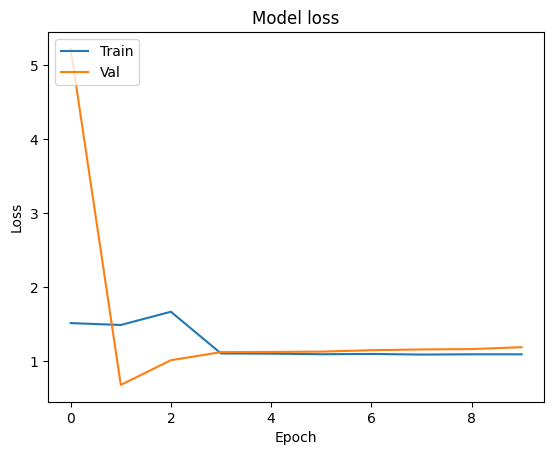

In [61]:
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

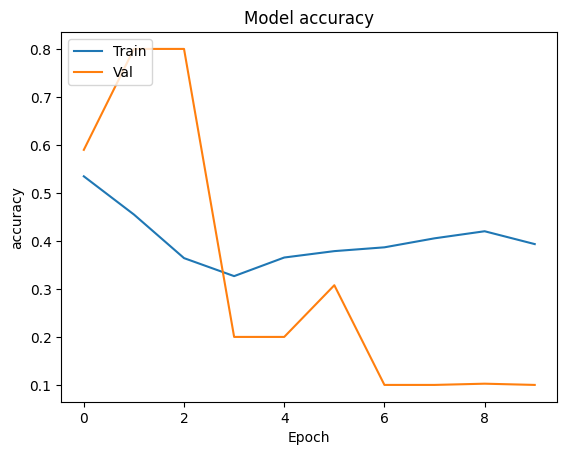

In [63]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()